In [1]:
import gymnasium as gym
import numpy as np
from enum import Enum
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### I am choosing the B.2 Traffic Light Control environment

In [4]:
class LightState(Enum):
    RED = 0
    YELLOW = 1
    GREEN = 2

class Direction(Enum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3

@dataclass
class Car:
    direction: Direction
    wait_time: int
    position: int

class TrafficLightEnv():
    
    def __init__(self, deterministic=True, max_cars=50, max_steps=100):
        
        self.deterministic = deterministic
        self.max_cars = max_cars
        self.max_steps = max_steps
        self.processed_cars = 0
        self.current_step = 0
        
        self.action_space = gym.spaces.Discrete(4) 
        
        self.light_states = {direction: LightState.RED for direction in Direction}
        self.queues: Dict[Direction, List[Car]] = {direction: [] for direction in Direction}
        self.green_timer = 0
        self.green_duration = 3
        self.yellow_timer = 0
        self.yellow_duration = 2 
        self.last_action = None
        
        # self.deterministic_pattern = {
        #     Direction.NORTH: 2,  
        #     Direction.SOUTH: 3,
        #     Direction.EAST: 4,
        #     Direction.WEST: 2
        # }
    
    def _is_legal_action(self, action: int) -> bool:
        if self.green_timer >0 or self.yellow_timer > 0:
            return True
        if self.last_action is not None and self.light_states[Direction(action)] == LightState.GREEN:
            return False
        return True
    
    def _update_light_states(self, action: int):
        if self.green_timer >0 or self.yellow_timer > 0:
            return
        
        direction = Direction(action)
        
        if self.light_states[direction] != LightState.GREEN:
            for d in Direction:
                if self.light_states[d] == LightState.GREEN:
                    self.light_states[d] = LightState.YELLOW
                    self.yellow_timer = self.yellow_duration
            
        if self.yellow_timer == 0:
            for d in Direction:
                if d == direction:
                    self.light_states[d] = LightState.GREEN
                    self.green_timer = self.green_duration
                else:
                    self.light_states[d] = LightState.RED
    
    def _add_new_cars(self):
        
        rush_hour_start = 10
        rush_hour_end = 30
    
        if rush_hour_start <= self.current_step <= rush_hour_end:
            print('\nRUSH HOUR')
            arrival_prob = {
                Direction.NORTH: 0.5, 
                Direction.SOUTH: 0.45,
                Direction.EAST: 0.4,
                Direction.WEST: 0.45
            }
            deterministic_pattern = {
                Direction.NORTH: 3,
                Direction.SOUTH: 2,
                Direction.EAST: 5,
                Direction.WEST: 4
            }
        else:
            arrival_prob = {
                Direction.NORTH: 0.2,
                Direction.SOUTH: 0.15,
                Direction.EAST: 0.1,
                Direction.WEST: 0.15
            }
            deterministic_pattern = {
                Direction.NORTH: 6,
                Direction.SOUTH: 7,
                Direction.EAST: 8,
                Direction.WEST: 7
            }
    
        for direction in Direction:
            if self.deterministic:
                if self.current_step % deterministic_pattern[direction] == 0:
                    self.queues[direction].append(Car(direction, 0, len(self.queues[direction])))
                    print(f"Car added in {Direction(direction)}")
            else:
                if np.random.random() < arrival_prob[direction]:
                    self.queues[direction].append(Car(direction, 0, len(self.queues[direction])))
                    print(f"Car added in {Direction(direction)}")

    
    def _process_cars(self):
        reward = 0
        for direction in Direction:
            if self.light_states[direction] == LightState.GREEN and self.queues[direction]:
                cars_to_process = min(1, len(self.queues[direction]))
                for _ in range(cars_to_process):
                    car = self.queues[direction].pop(0)
                    reward += 5
                    self.processed_cars += 1
        print('No of cars processed',self.processed_cars)
        return reward
    
    def _update_wait_times(self):
        waiting_penalty = 0
        for direction in Direction:
            for car in self.queues[direction]:
                car.wait_time += 1
                waiting_penalty -= 1
        print('Total cars waiting',-waiting_penalty)
        return waiting_penalty
    
    def step(self, action: int):
        assert self.action_space.contains(action)
        
        if not self._is_legal_action(action):
            return -10, {"illegal_action": True}
        
        self._update_light_states(action)
        
        reward = self._process_cars()
        
        self._add_new_cars()
        
        reward += self._update_wait_times()
        
        self.current_step += 1
        if self.green_timer > 0:
            self.green_timer -= 1
        elif self.yellow_timer > 0:
            self.yellow_timer -= 1

        if self.processed_cars >= self.max_cars:
            return -10, {"max_cars_processed": True}
        elif self.current_step >= self.max_steps:
            return -10, {"max_steps_reached": True}
        
        
        return reward, {}
    
    def reset(self):
        
        self.light_states = {direction: LightState.RED for direction in Direction}
        self.queues = {direction: [] for direction in Direction}
        self.yellow_timer = 0
        self.processed_cars = 0
        self.current_step = 0
        self.last_action = None
        
        return
    
    def render(self):
        plt.clf()
        plt.figure(figsize=(4, 4))
        
        plt.plot([-2, 2], [0, 0], 'k-', linewidth=2)
        plt.plot([0, 0], [-2, 2], 'k-', linewidth=2)
        
        colors = {
            LightState.RED: 'red',
            LightState.YELLOW: 'yellow',
            LightState.GREEN: 'green'
        }
        
        positions = {
            Direction.NORTH: (0, 0.25),
            Direction.SOUTH: (0, -0.25),
            Direction.EAST: (0.25, 0),
            Direction.WEST: (-0.25, 0)
        }
        
        for direction in Direction:
            pos = positions[direction]
            color = colors[self.light_states[direction]]
            plt.plot(pos[0], pos[1], 'o', color=color, markersize=5)
            
            queue_length = len(self.queues[direction])
            if direction in [Direction.NORTH, Direction.SOUTH]:
                for i in range(queue_length):
                    rect = patches.Rectangle(
                        (pos[0] - 0.1, pos[1] + (i * 0.2) * (1 if direction == Direction.NORTH else -1)),
                        0.2, 0.1, linewidth=0, edgecolor='blue', facecolor='blue'
                    )
                    plt.gca().add_patch(rect)
            else:
                for i in range(queue_length):
                    rect = patches.Rectangle(
                        (pos[0] + (i * 0.2) * (1 if direction == Direction.EAST else -1), pos[1] - 0.05),
                        0.2, 0.1, linewidth=0, edgecolor='blue', facecolor='blue'
                    )
                    plt.gca().add_patch(rect)
    
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.title(f'Step: {self.current_step}, Processed Cars: {self.processed_cars}')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

def run_random_agent(env, n_steps=100):
    env.reset()
    total_reward = 0
    env.render()
    for step in range(n_steps):
        action = env.action_space.sample()
        print(f"\nAction: {Direction(action).name}")
        reward, info = env.step(action)
        if "illegal_action" in info:
            print("\nEpisode finished early - Illegal Action")
            break
        elif "max_steps_reached" in info:
            print("\nEpisode finished early - Reached Maximum Steps")
            break
        elif "max_cars_processed" in info:
            print("\nEpisode finished early - Processed Maximum Cars")
            break
        env.render()
        total_reward += reward
        
        print(f"\nStep {step + 1}")
        
        print(f"Reward: {reward}")
        print(f"Total Reward: {total_reward}")
            
    return total_reward

<Figure size 640x480 with 0 Axes>

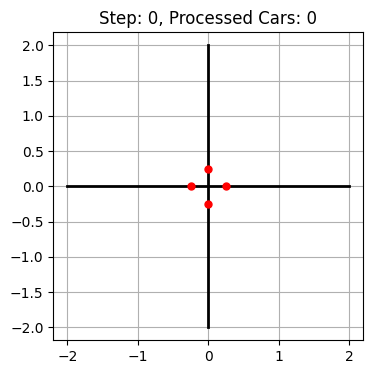


Action: EAST
No of cars processed 0
Car added in Direction.EAST
Total cars waiting 1


<Figure size 640x480 with 0 Axes>

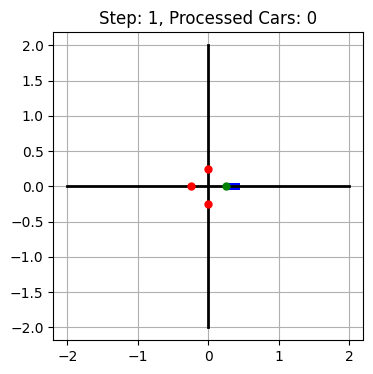


Step 1
Reward: -1
Total Reward: -1

Action: WEST
No of cars processed 1
Car added in Direction.NORTH
Total cars waiting 1


<Figure size 640x480 with 0 Axes>

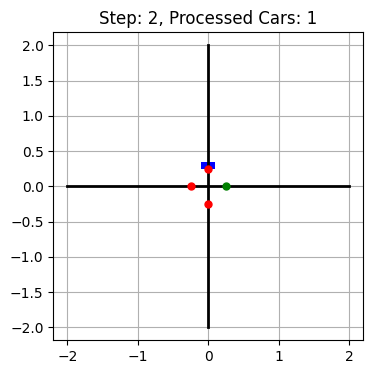


Step 2
Reward: 4
Total Reward: 3

Action: SOUTH
No of cars processed 1
Car added in Direction.WEST
Total cars waiting 2


<Figure size 640x480 with 0 Axes>

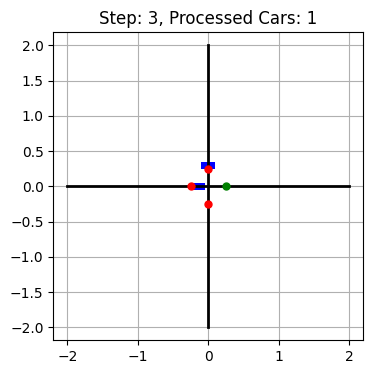


Step 3
Reward: -2
Total Reward: 1

Action: NORTH
No of cars processed 1
Car added in Direction.NORTH
Total cars waiting 3


<Figure size 640x480 with 0 Axes>

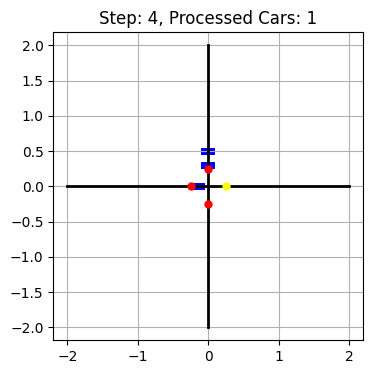


Step 4
Reward: -3
Total Reward: -2

Action: EAST
No of cars processed 1
Car added in Direction.EAST
Total cars waiting 4


<Figure size 640x480 with 0 Axes>

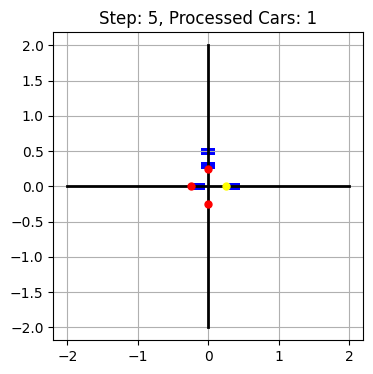


Step 5
Reward: -4
Total Reward: -6

Action: NORTH
No of cars processed 2
Car added in Direction.NORTH
Total cars waiting 4


<Figure size 640x480 with 0 Axes>

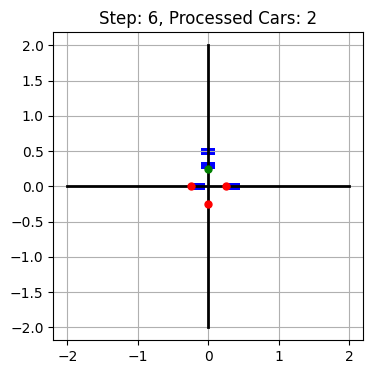


Step 6
Reward: 1
Total Reward: -5

Action: EAST
No of cars processed 3
Total cars waiting 3


<Figure size 640x480 with 0 Axes>

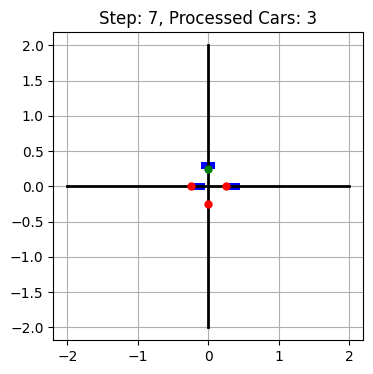


Step 7
Reward: 2
Total Reward: -3

Action: SOUTH
No of cars processed 4
Total cars waiting 2


<Figure size 640x480 with 0 Axes>

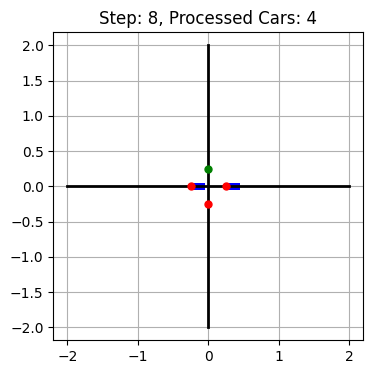


Step 8
Reward: 3
Total Reward: 0

Action: SOUTH
No of cars processed 4
Car added in Direction.NORTH
Car added in Direction.SOUTH
Car added in Direction.WEST
Total cars waiting 5


<Figure size 640x480 with 0 Axes>

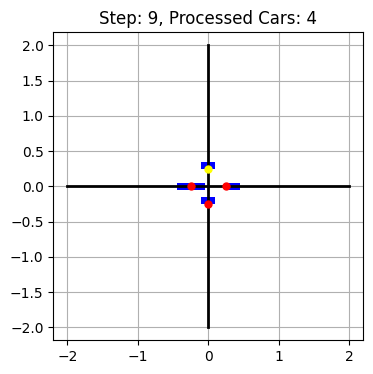


Step 9
Reward: -5
Total Reward: -5

Action: EAST
No of cars processed 4
Total cars waiting 5


<Figure size 640x480 with 0 Axes>

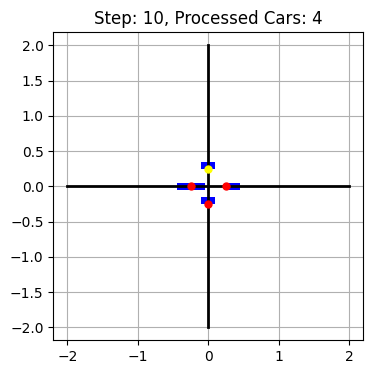


Step 10
Reward: -5
Total Reward: -10

Action: NORTH
No of cars processed 5

RUSH HOUR
Car added in Direction.EAST
Car added in Direction.SOUTH
Total cars waiting 6


<Figure size 640x480 with 0 Axes>

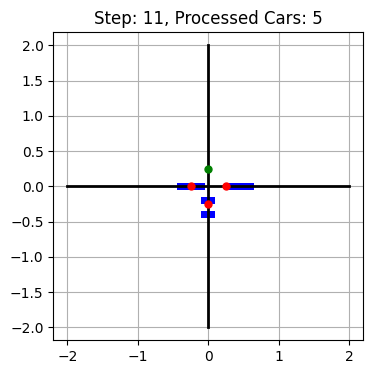


Step 11
Reward: -1
Total Reward: -11

Action: EAST
No of cars processed 5

RUSH HOUR
Car added in Direction.NORTH
Car added in Direction.EAST
Total cars waiting 8


<Figure size 640x480 with 0 Axes>

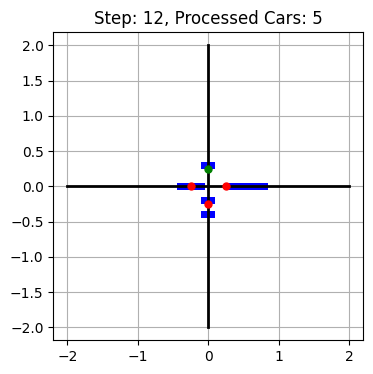


Step 12
Reward: -8
Total Reward: -19

Action: EAST
No of cars processed 6

RUSH HOUR
Car added in Direction.NORTH
Car added in Direction.SOUTH
Total cars waiting 9


<Figure size 640x480 with 0 Axes>

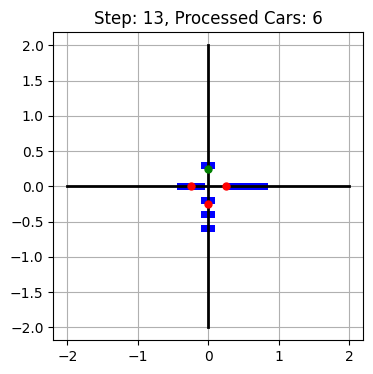


Step 13
Reward: -4
Total Reward: -23

Action: EAST
No of cars processed 6

RUSH HOUR
Car added in Direction.NORTH
Car added in Direction.EAST
Car added in Direction.SOUTH
Car added in Direction.WEST
Total cars waiting 13


<Figure size 640x480 with 0 Axes>

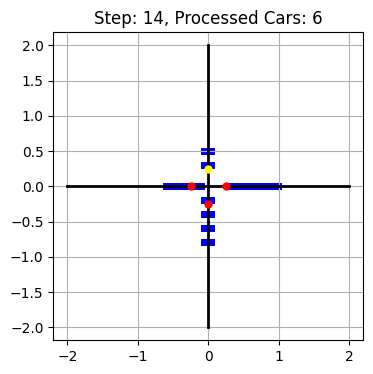


Step 14
Reward: -13
Total Reward: -36

Action: NORTH
No of cars processed 6

RUSH HOUR
Car added in Direction.SOUTH
Car added in Direction.WEST
Total cars waiting 15


<Figure size 640x480 with 0 Axes>

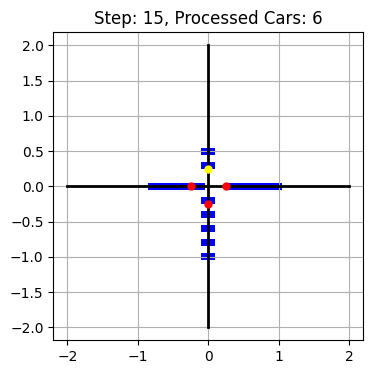


Step 15
Reward: -15
Total Reward: -51

Action: EAST
No of cars processed 7

RUSH HOUR
Car added in Direction.SOUTH
Total cars waiting 15


<Figure size 640x480 with 0 Axes>

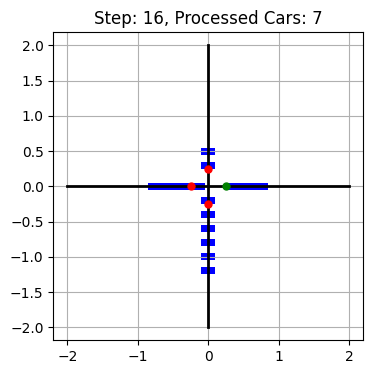


Step 16
Reward: -10
Total Reward: -61

Action: WEST
No of cars processed 8

RUSH HOUR
Car added in Direction.SOUTH
Total cars waiting 15


<Figure size 640x480 with 0 Axes>

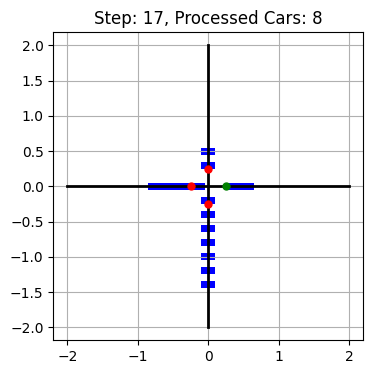


Step 17
Reward: -10
Total Reward: -71

Action: EAST
No of cars processed 9

RUSH HOUR
Car added in Direction.WEST
Total cars waiting 15


<Figure size 640x480 with 0 Axes>

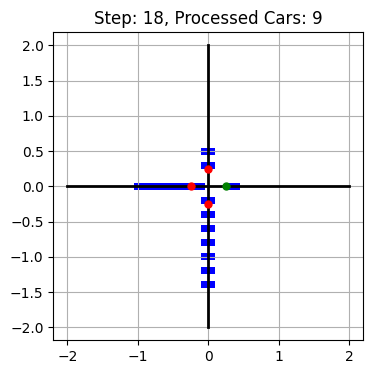


Step 18
Reward: -10
Total Reward: -81

Action: NORTH
No of cars processed 9

RUSH HOUR
Car added in Direction.SOUTH
Total cars waiting 16


<Figure size 640x480 with 0 Axes>

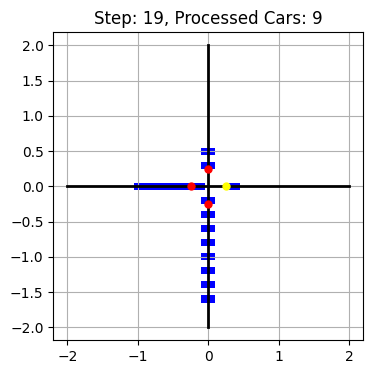


Step 19
Reward: -16
Total Reward: -97

Action: SOUTH
No of cars processed 9

RUSH HOUR
Car added in Direction.EAST
Car added in Direction.SOUTH
Car added in Direction.WEST
Total cars waiting 19


<Figure size 640x480 with 0 Axes>

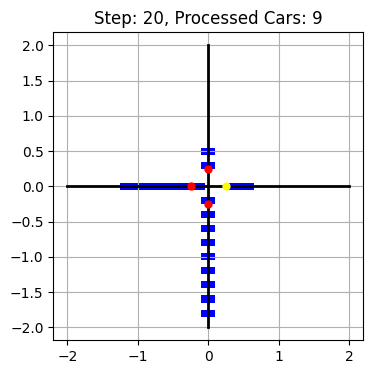


Step 20
Reward: -19
Total Reward: -116

Action: NORTH
No of cars processed 10

RUSH HOUR
Car added in Direction.SOUTH
Total cars waiting 19

Episode finished early - Processed Maximum Cars
Total Reward: -116


In [5]:
env = TrafficLightEnv(deterministic=False,max_cars=10, max_steps=100)
total_reward = run_random_agent(env)
print(f"Total Reward: {total_reward}")